### 잡음제거 : 오토인코더 활용
오토인코더는 데이터의 중요한 특징을 담고있는 잠재표현을 구하는 데에 뛰어난 능력을 갖고 있다.  
그렇다면 잡음같은 중요하지 않은 데이터는 제거하고, 중요한 정보만 남기는 일을 할 수 있지 않을까?  
07_quiz.ipynb에서 KNN을 이용해 잡음을 제거했던 프로젝트를 오토인코더를 이용해 개선해보자.
+ 디코더의 Conv2DTranspose layer의 output shape가 (None, 63, 63, 3)이므로 imgR, imgC를 63으로 지정한다.  
=> 인코더의 input_shape는 (63,63,3)이 되어야 한다.

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

from tensorflow import keras

<Figure size 432x288 with 0 Axes>

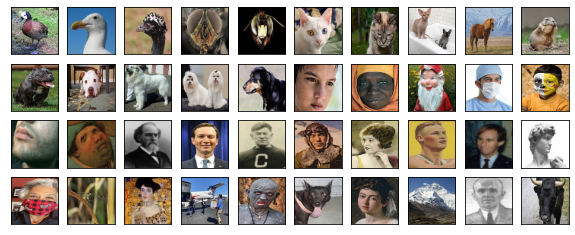

In [16]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj1/40/'
imgR, imgC, channel = 63, 63, 3
images = []

for i in range(40):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (imgR, imgC, channel))
    images.append(img)
    
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol, nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1:
                axis = ax[j]
            else:
                axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol + j])
            
plot_images(4, 10, images)

<Figure size 432x288 with 0 Axes>

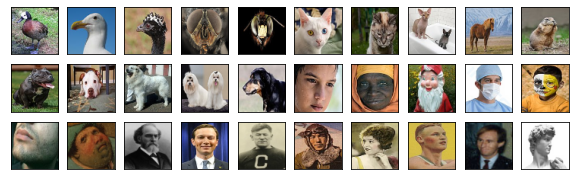

<Figure size 432x288 with 0 Axes>

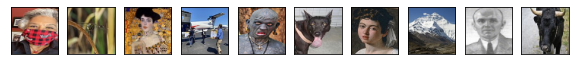

In [17]:
X = np.array(images[:30])        #훈련데이터 30개
X_test = np.array(images[30:])   #검증데이터 10개

plot_images(3, 10, X)
plot_images(1, 10, X_test)       #여기 훈련/검증 데이터들은 오토인코더의 정답레이블로 사용

<Figure size 432x288 with 0 Axes>

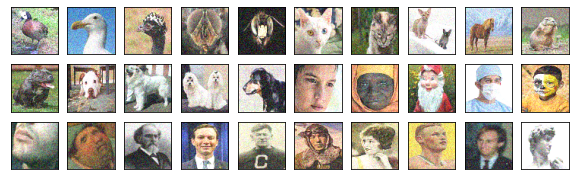

<Figure size 432x288 with 0 Axes>

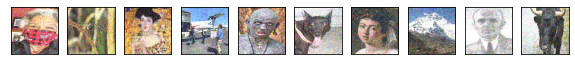

In [25]:
#노이즈(정규분포를 따름) 섞인 이미지 만들기
X_noisy = X + np.random.rand(len(X), imgR, imgC, channel) * 0.3
X_noisy = np.clip(X_noisy, 0, 1)              #노이즈가 더해졌기 때문에 0~1 사이를 벗어나지 않도록 클리핑
X_test_noisy = X_test + np.random.rand(len(X_test), imgR, imgC, channel) * 0.3
X_test_noisy = np.clip(X_test_noisy, 0, 1)

plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)   #노이즈 섞인 이미지들은 오토인코더 훈련용으로 사용

In [19]:
cnn_encoder = keras.models.Sequential([keras.layers.Conv2D(filters=16, kernel_size=3, strides=(3,3), activation='elu', input_shape=(64,64,3)),
                                       keras.layers.Conv2D(filters=8, kernel_size=3, activation='elu'),
                                       keras.layers.Flatten(),
                                       keras.layers.Dense(32*32, activation='elu')])   #잠재표현 출력

cnn_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 21, 21, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 8)         1160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2888)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2958336   
Total params: 2,959,944
Trainable params: 2,959,944
Non-trainable params: 0
_________________________________________________________________


In [20]:
cnn_decoder = keras.models.Sequential([keras.layers.Dense(2888, input_shape=(32*32,), activation='elu'),    #encoder의 Flatten layer의 output shape만큼 노드개수 지정
                                       keras.layers.Reshape(target_shape=(19,19,8)),    #Flatten layer 이전 layer의 output shape로 맞추기
                                       keras.layers.Conv2DTranspose(filters=16, kernel_size=3, activation='elu'),
                                       keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(3,3), activation='elu')])

cnn_decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2888)              2960200   
_________________________________________________________________
reshape_2 (Reshape)          (None, 19, 19, 8)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 21, 21, 16)        1168      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 63, 63, 3)         435       
Total params: 2,961,803
Trainable params: 2,961,803
Non-trainable params: 0
_________________________________________________________________


In [26]:
cnn_autoencoder = keras.models.Sequential([cnn_encoder, cnn_decoder])

cnn_autoencoder.compile(loss='mse')

history = cnn_autoencoder.fit(X_noisy, X, epochs=100, verbose=0)    #노이즈 섞인 이미지를 입력으로, 깨끗한 데이터를 레이블로 지정해 학습

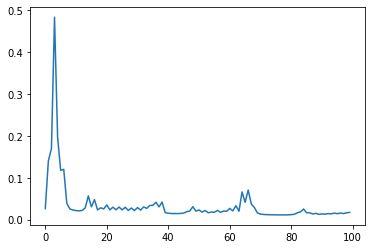

In [27]:
plt.plot(history.history['loss']);

잡음을 제거하는 오토인코더를 학습시켰으니, 잡음을 제거해보자.  
우선 훈련데이터의 잡음을 얼마나 잘 제거하는지 확인해보자.

<Figure size 432x288 with 0 Axes>

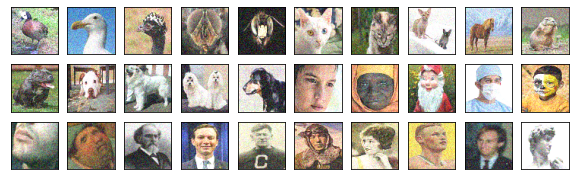

<Figure size 432x288 with 0 Axes>

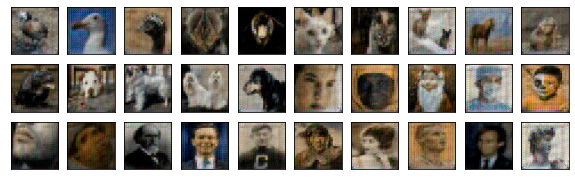

In [30]:
denoised_X_noisy = cnn_autoencoder.predict(X_noisy)
denoised_X_noisy = np.clip(denoised_X_noisy, 0, 1)

plot_images(3, 10, X_noisy)
plot_images(3, 10, denoised_X_noisy)

색깔이 줄어들었고, 잡음도 그다지 개선된 것같아 보이진 않는다.  
검증데이터에 대해서도 적용해보자.

<Figure size 432x288 with 0 Axes>

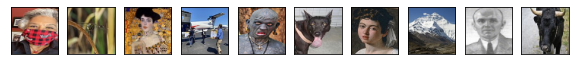

<Figure size 432x288 with 0 Axes>

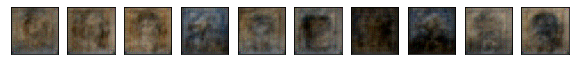

In [32]:
denoised_X_test = cnn_autoencoder.predict(X_test)
denoised_X_test = np.clip(denoised_X_test, 0, 1)

plot_images(1, 10, X_test)
plot_images(1, 10, denoised_X_test)

훈련에 사용되지 않은 검증데이터에 대해서는 거의 작동하지 않는 것으로 보인다.  

이것은 데이터의 개수가 너무 적어 과적합이 이루어졌기 때문일 것이다.  
이 문제를 극복하기 위해 데이터를 증강해보자.  
07_quiz.ipynb에서도 사용했던 keras의 ImageDataGenerator 클래스를 사용하면 된다.

In [36]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range=360,         #이미지 회전
                                                                zoom_range=0.1,            #확대
                                                                shear_range=0.1,           #축소
                                                                width_shift_range=0.1,     #기울이기
                                                                height_shift_range=0.1,    #기울이기
                                                                horizontal_flip=True,      #상하반전
                                                                vertical_flip=True)        #좌우반전

y_aug = X.reshape(-1, imgR, imgC, channel)  #깨끗한 이미지 X를 증강한 데이터
it = image_generator.flow(y_aug)            #원본 이미지 데이터를 넘겨 iterator 생성 => next() 호출할 때마다 데이터 반환
nData = y_aug.shape[0]                      #원본 이미지 개수

X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel) * 0.3  #y_aug에 잡음 섞어 입력데이터 만들기

n_aug = 500

for i in range(n_aug):
    new_y = it.next()                 #image generator가 새로운 이미지 생성 => 새로운 레이블 
    new_X = new_y + np.random.randn(nData, imgR, imgC, channel) * 0.3   #new_y에 잡음 추가
    y_aug = np.append(y_aug, new_y)
    X_aug = np.append(X_aug, new_X)
    
y_aug = y_aug.reshape(-1, imgR, imgC, channel)  
X_aug = X_aug.reshape(-1, imgR, imgC, channel)    

print(y_aug.shape)

(15030, 63, 63, 3)


<Figure size 432x288 with 0 Axes>

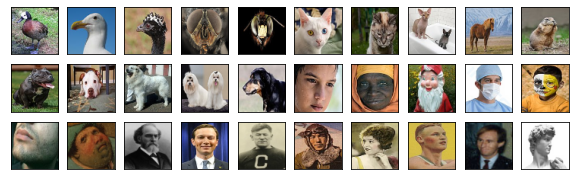

<Figure size 432x288 with 0 Axes>

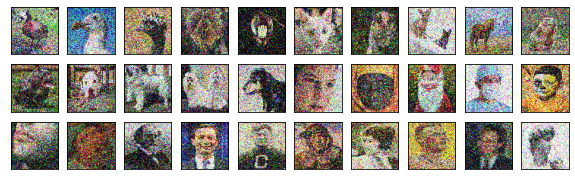

In [37]:
y_aug = np.clip(y_aug, 0, 1)
X_aug = np.clip(X_aug, 0, 1)

plot_images(3, 10, y_aug[:30])   
plot_images(3, 10, X_aug[:30])   

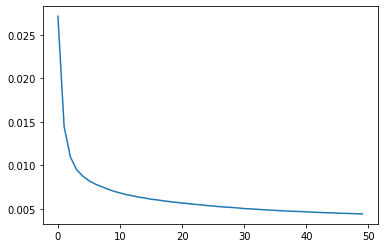

In [38]:
history = cnn_autoencoder.fit(X_aug, y_aug, epochs=50, verbose=0)

plt.plot(history.history['loss']);

<Figure size 432x288 with 0 Axes>

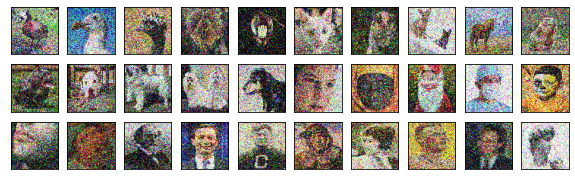

<Figure size 432x288 with 0 Axes>

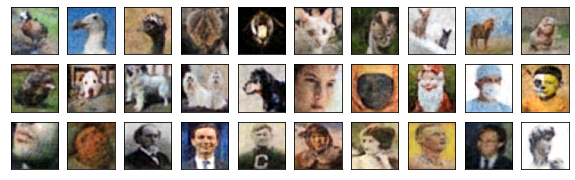

In [39]:
#증강데이터로 훈련된 오토인코더로 훈련데이터 잡음제거
denoised_X_aug = cnn_autoencoder.predict(X_aug)
denoised_X_aug = np.clip(denoised_X_aug, 0, 1)

plot_images(3, 10, X_aug[:30])
plot_images(3, 10, denoised_X_aug[:30])

<Figure size 432x288 with 0 Axes>

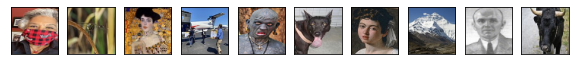

<Figure size 432x288 with 0 Axes>

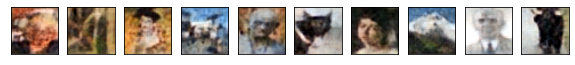

In [40]:
#증강데이터로 훈련된 오토인코더로 검증데이터 잡음제거
denoised_X_test = cnn_autoencoder.predict(X_test)
denoised_X_test = np.clip(denoised_X_test, 0, 1)

plot_images(1, 10, X_test)
plot_images(1, 10, denoised_X_test)

데이터를 늘려 훈련하니 새로운 데이터에 대해서도 잡음을 잘 제거하고 부드러운 이미지를 생성하는 것을 볼 수 있다.